# IMPORT STATEMENTS

In [1]:
!TMPDIR=/home/mgill/ pip install --cache-dir=/home/mgill/ --build /home/mgill/ pandas numpy sklearn xgboost matplotlib tensorflow==2.1.0 keras==2.2.4 fastai python-dateutil scikit-optimize scikit-learn==0.21 graphviz

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf; print(tf.__version__)
import keras; print(keras.__version__)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.regularizers import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from random import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation
from math import sqrt
from statistics import mean
from sklearn.metrics import mean_squared_error, r2_score
import skopt
from skopt.searchcv import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import GridSearchCV
import pickle
from collections import OrderedDict
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.impute import SimpleImputer

2.1.0
2.2.4


Using TensorFlow backend.
/home/mgill/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
def new_prep_data(tt_file, ho_file):
    imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
    my_list = []
    x = 0 
    for chunk in pd.read_csv(tt_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            tt_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(tt_pheno.shape)
            tt_pheno = np.reshape(tt_pheno,(len(tt_pheno),1))
            print(tt_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    tt_vcf = pd.concat(my_list, axis = 1)
    my_list = []
    x=0
    for chunk in pd.read_csv(ho_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            ho_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(ho_pheno.shape)
            ho_pheno = np.reshape(ho_pheno,(len(ho_pheno),1))
            print(ho_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    ho_vcf = pd.concat(my_list, axis = 1)
    print(tt_vcf.shape)
    print(ho_vcf.shape)
    return tt_vcf, ho_vcf, tt_pheno, ho_pheno

In [ ]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("SCC_Merged_filtered.csv_train_test.csv_5pcnt.csv", "SCC_Merged_filtered.csv_holdout.csv_5pcnt.csv")

In [ ]:
#if it hasn't been run and saved before
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe = ohe.fit(tt_vcf)

In [ ]:
pickle.dump(ohe, open("SCC_ohe.dat", "wb"))

In [4]:
#if need or have new holdout data etc.
ohe = pickle.load(open("SCC_ohe.dat", "rb"))

In [ ]:
print(tt_vcf.shape)
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

In [5]:
def find_snp_from_header(ohe,snp_num):
    count = 0
    snp = "Not found"
    found = False
    i = 0
    while i < len(ohe.categories_) and (found == False):
        j = 0
        while j < len(ohe.categories_[i]):
            if(count == snp_num):
                snp = ohe.categories_[i][j]
                found = True
                break
            count = count + 1
            j = j + 1
        i = i + 1
    return snp

In [6]:
## TESTING IF IT WORKS
my_snp = find_snp_from_header(ohe, 462793)
print(my_snp)

T/C


# XGBOOST ML Model

In [ ]:
print(tt_vcf.shape)
print(tt_pheno.shape)
seed = randint(0,5000)
X_train, X_test, y_train, y_test = train_test_split(tt_vcf, tt_pheno, test_size=0.2, random_state=seed)
print(X_test.shape)
print("seed is " + str(seed))

In [ ]:
space ={'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'min_child_weight': Integer(0, 10),
        'max_depth': Integer(0, 50),
        'max_delta_step': Integer(0, 20),
        'subsample': Real(0.01, 1.0, 'uniform'),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
        'gamma': Real(1e-9, 0.5, 'log-uniform'),
        'min_child_weight': Integer(0, 5),
        'n_estimators': Integer(50, 200),
        'scale_pos_weight': Real(1e-6, 500, 'log-uniform')}

In [ ]:
def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = xgb_bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

In [ ]:
xgbcl = xgb.XGBClassifier(objective='multi:softmax', num_class=4)
xgb_bayes_search = BayesSearchCV(xgbcl, space, n_iter=32, # specify how many iterations
                                    scoring=None, n_jobs=1, cv=5, verbose=3, random_state=42, n_points=12,
                                 refit=True)
xgb_bayes_search.fit(X_train, y_train.ravel(), callback = on_step)
print(xgb_bayes_search.best_params_)

In [ ]:
print(xgb_bayes_search.best_params_)
model = xgb.XGBClassifier(**xgb_bayes_search.best_params_, objective='multi:softmax', num_class=4)

In [ ]:
##if not in same run as optimisation
best_params = OrderedDict([('colsample_bylevel', 0.25617325301227906), ('colsample_bytree', 0.7083937150495909), ('gamma', 2.41812432168581e-07), ('learning_rate', 0.13965555720269418), ('max_delta_step', 10), ('max_depth', 27), ('min_child_weight', 1), ('n_estimators', 76), ('reg_alpha', 3.178148842971562e-08), ('reg_lambda', 0.005381781269387993), ('scale_pos_weight', 0.23835043249575294), ('subsample', 0.9559763235078597)])
model = xgb.XGBClassifier(**best_params, objective='multi:softmax', num_class=4)

In [ ]:
## DO MORE STUFF HERE when OPTIMISED

In [ ]:
def eval_k_fold(m, x, y, k, hx, hy):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = StratifiedKFold(n_splits=k,shuffle=False)
    fig1 = plt.figure(figsize=[12,12])

    tprs = []
    aucs = []
    results = []
    mean_fpr = np.linspace(0,1,100)
    high = 0
    best = m
    i = 1
    for train,test in cv.split(x,y):
        prediction = m.fit(x[train],y[train].ravel()).predict_proba(x[test])
        print("variables for auroc curve done. Processing fold accuracy + checking best model")
        y_pred = m.predict(x[test])
        predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        accuracy = accuracy_score(y[test], predictions)
        pcent = accuracy * 100.0
        print("The accuracy of this model is" + str(pcent))
        if(pcent > high):
            high = pcent
            best = m
       # fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
       # tprs.append(interp(mean_fpr, fpr, tpr))
       # roc_auc = auc(fpr, tpr)
       # aucs.append(roc_auc)
        results.append(pcent)
       # plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1

   # plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
   # mean_tpr = np.mean(tprs, axis=0)
   # mean_auc = auc(mean_fpr, mean_tpr)
   # plt.plot(mean_fpr, mean_tpr, color='blue',
    #         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
    
    holdout_pred = best.predict(hx)
    predictions = [round(value) for value in holdout_pred]
    #sees how accurate the model was when testing the test set
    accuracy = accuracy_score(hy, predictions)
    pcent = accuracy * 100.0
    print(pcent)
    xgb_predictions = best.predict(hx)
    xgb_probs = best.predict_proba(hx)[:, 1]
    #model_fpr, model_tpr, my_roccy = evaluate_model(xgb_predictions, xgb_probs, hy)
    #plt.plot(model_fpr, model_tpr, 'r', label = 'Holdout Data'+my_roccy, lw=2)
    
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.title('ROC Flower Colour Training Model & Holdout Data')
    #plt.legend(loc="lower right")
    #plt.show()

    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    print("Holdout Accuracy: %.2f%%" % (pcent))
    
    return best

In [ ]:
print(tt_vcf.shape)
print(tt_pheno.shape)
print(ho_vcf.shape)
print(ho_pheno.shape)
 #if optimised in same session, other enter manually below
#this function should average out 10 folds and training, with inital params optimised
#average accuracy and std should be calculated along with a nice AUROC graph of train/test models
#best model should be extracted for use on holdout set
best_model = eval_k_fold(model, tt_vcf, tt_pheno, 10, ho_vcf, ho_pheno)

In [ ]:
import pickle
pickle.dump(best_model, open("SCC_kfold_10_tt_from_all.pickle.dat", "wb"))

In [7]:
#only load if not generated in same session
best_model = pickle.load(open("SCC_kfold_10_tt_from_all.pickle.dat", "rb"))

In [ ]:
## DO SNPS of importance

<Figure size 1440x1440 with 0 Axes>

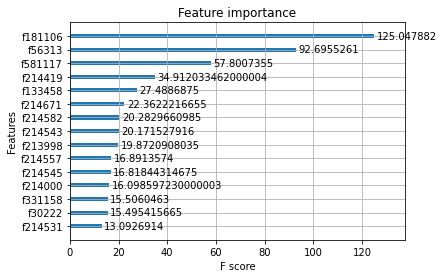

In [8]:
from xgboost import plot_importance
from matplotlib import pyplot
#best_model = pickle.load(open("FC_kfold_10_tt_from_all.pickle.dat", "rb"))
plt.figure(figsize = (20, 20))
plot_importance(best_model, max_num_features=15, importance_type='gain', height=0.3)
pyplot.show()

In [9]:
#This function essentially returns an array of dataframe headers the length of OHE'd input SNPs for training data
#EG. It will be able to determine that feature 357310 is Gm13_17683957 but not what allele it is
#eg. feature 357309 357310 and 357311 may all be one hot encoded versions of all possible values of Gm13_17683957
#iterating through the saved OHE will by able to determine what specific allele the feature is but cannot determine
#what SNP header it belongs to. Therefore combining these two methods you can determine both allele and SNP
snp = []
imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
fs_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
x = 0
n_headers = []
le = LabelEncoder()
#while (i < 10):
for chunk in pd.read_csv("SCC_Merged_filtered.csv_train_test.csv_5pcnt.csv", chunksize=10000, index_col="Unnamed: 0"):
    chunk = chunk.T
    if 'Value' in chunk.columns:
        print("dropping value so it doesn't include that in headers")
        chunk = chunk.drop(columns=['Value'])
    headers = chunk.columns
    row_idx = chunk.index
    chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
    #since imputing makes a numpy array have to turn back into PD for label encoding
    chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
    chunk = chunk.apply(lambda col: le.fit_transform(col))
    c_headers = chunk.columns
    y = 0
    for column in chunk:
        d = (chunk[column].nunique())
        n_headers.extend([c_headers[y] for i in range(d)])
        #print(n_headers)
        #print(l)
        #n_headers.append(c_headers[y] * d)
        #print(n_headers)
        y = y + 1
    #to double check that it would indeed be one hot encoded with this amount of columns
    chunk = fs_ohe.fit_transform(chunk)
    x = x + chunk.shape[1]
    print("my X value is: " + str(x))
    print(chunk.shape)
    print("my header list is: " + str(len(n_headers)))
print(len(n_headers))

my X value is: 28494
(620, 28494)
my header list is: 28494
my X value is: 57334
(620, 28840)
my header list is: 57334
my X value is: 86364
(620, 29030)
my header list is: 86364
my X value is: 115483
(620, 29119)
my header list is: 115483
my X value is: 144269
(620, 28786)
my header list is: 144269
my X value is: 173493
(620, 29224)
my header list is: 173493
my X value is: 202638
(620, 29145)
my header list is: 202638
my X value is: 231595
(620, 28957)
my header list is: 231595
my X value is: 260443
(620, 28848)
my header list is: 260443
my X value is: 289243
(620, 28800)
my header list is: 289243
my X value is: 318230
(620, 28987)
my header list is: 318230
my X value is: 347155
(620, 28925)
my header list is: 347155
my X value is: 376380
(620, 29225)
my header list is: 376380
my X value is: 405248
(620, 28868)
my header list is: 405248
my X value is: 434615
(620, 29367)
my header list is: 434615
my X value is: 463674
(620, 29059)
my header list is: 463674
my X value is: 492799
(620, 29

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
fs = [181106,56313,581117,214419,133458,214671,214582,214543,213998,214557,214545,214000,331158,30222,214531]
scores = [125,92.7,57.8,34.9,27.5,22.4,20.3,20.2,19.9,16.9,16.8,16.1,15.51,15.5,13.1]
snp_label = []
for jj in fs:
    jj_allele = find_snp_from_header(ohe, jj)
    this_snp = (n_headers[jj] + ' ('+str(jj_allele)+')')
    print(this_snp)
    snp_label.append(this_snp)
snp_label.reverse()
scores.reverse()
print(len(scores))
print(len(snp_label))
plt.barh(snp_label,scores)
plt.title('SNP Importance XGBoost Seed Coat Colour')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

In [10]:
my_dict = best_model.get_booster().get_score(importance_type="gain")

In [11]:
def rename_f_header(fn,n_headers,ohe):
    fn = fn[1:]
    fn = int(fn)
    allele = find_snp_from_header(ohe, fn)
    this_snp = (n_headers[fn] + ' ('+str(allele)+')')
    return this_snp

In [12]:
#convert feature to actual SNP name
i = 0
new_dict = {}
for key in my_dict:
    new_key = rename_f_header(key, n_headers, ohe)
    new_dict[new_key] = my_dict[key]
    i = i + 1
    print(str(i))
    if(my_dict):
        continue
    else:
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [13]:
new_fi = pd.Series(new_dict)
print(new_fi)
df = new_fi.to_frame()
df = df.rename(columns = {0:'F_Score(GAIN)'})
print(df)

Gm06_48831323 (G/G)    125.047882
Gm01_20816751 (C/A)      3.407623
Gm08_8792006 (T/T)      22.362222
Gm09_40394306 (C/C)     10.705885
Gm13_19050182 (C/C)      8.111638
                          ...    
Gm04_5428280 (T/T)       0.064938
Gm08_11806621 (A/A)      0.052873
Gm05_36162676 (T/T)      0.085195
Gm16_1334966 (C/C)       0.067094
Gm10_15082121 (A/A)      0.055978
Length: 1815, dtype: float64
                     F_Score(GAIN)
Gm06_48831323 (G/G)     125.047882
Gm01_20816751 (C/A)       3.407623
Gm08_8792006 (T/T)       22.362222
Gm09_40394306 (C/C)      10.705885
Gm13_19050182 (C/C)       8.111638
...                            ...
Gm04_5428280 (T/T)        0.064938
Gm08_11806621 (A/A)       0.052873
Gm05_36162676 (T/T)       0.085195
Gm16_1334966 (C/C)        0.067094
Gm10_15082121 (A/A)       0.055978

[1815 rows x 1 columns]


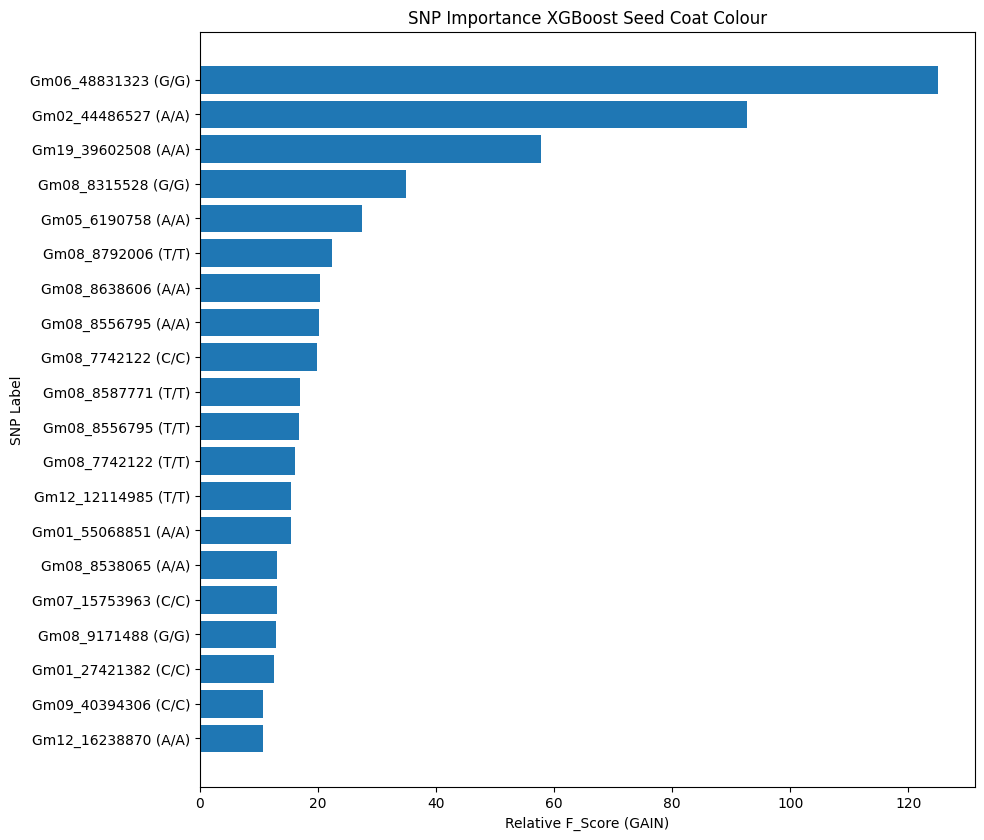

In [14]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
indexes = indexes[::-1]
values = values[::-1]
plt.barh(indexes, values)
plt.title('SNP Importance XGBoost Seed Coat Colour')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

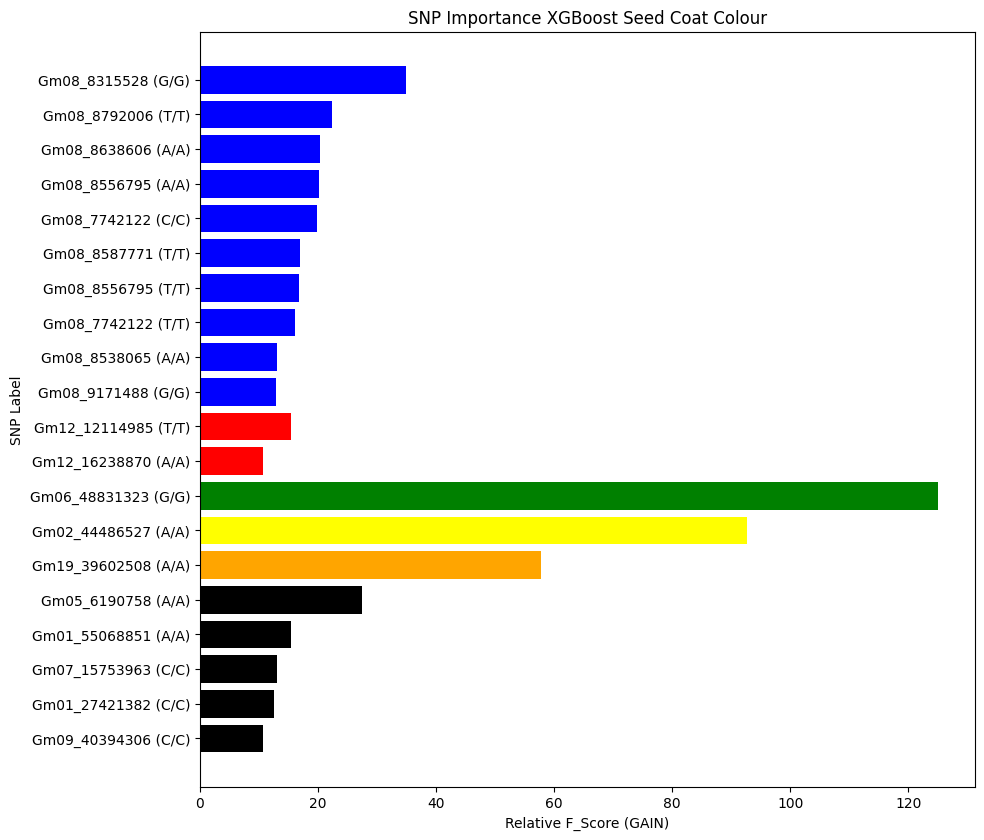

In [18]:
#generate figure object
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
#load in the 20 lardest values and their SNP label
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
#reverse to make the largest be at the front
indexes = indexes[::-1]
values = values[::-1]
#for each different chromosome you want to colour add a index(*_i) and value (*_v) array
#black would be colour for singular/notinteresting chromosomes
r_i = []
r_v = []
b_i = []
b_v = []
g_i = []
g_v = []
y_i = []
y_v = []
bl_i = []
bl_v = []
p_i = []
p_v = []
br_i = []
br_v = []
pu_i = []
pu_v = []
#for each value in the top n (default 20) check which chromosome it belongs to and add it to the colour array
i = 0
while i < len(indexes):
    if('Gm12' in indexes[i]):
        r_i.append(indexes[i])
        r_v.append(values[i])
    elif('Gm08' in indexes[i]):
        b_i.append(indexes[i])
        b_v.append(values[i])
    elif('Gm06' in indexes[i]):
        g_i.append(indexes[i])
        g_v.append(values[i])
    elif('Gm02' in indexes[i]):
        y_i.append(indexes[i])
        y_v.append(values[i])
    elif('Gm19' in indexes[i]):
        p_i.append(indexes[i])
        p_v.append(values[i])
   # elif('Gm04' in indexes[i]):
   #     br_i.append(indexes[i])
   #     br_v.append(values[i])
   # elif('Gm13' in indexes[i]):
   #     pu_i.append(indexes[i])
   #     pu_v.append(values[i])
    else:
        bl_i.append(indexes[i])
        bl_v.append(values[i])
    i = i + 1
#plot each of the arrays with appropriate colour and label graph
plt.barh(bl_i, bl_v, color="black")
plt.barh(br_i, br_v, color="brown")
plt.barh(pu_i, pu_v, color="purple")
plt.barh(p_i, p_v, color="orange")
plt.barh(y_i, y_v, color="yellow")
plt.barh(g_i, g_v, color="green")
plt.barh(r_i, r_v, color="red")
plt.barh(b_i, b_v, color="blue")
plt.title('SNP Importance XGBoost Seed Coat Colour')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

# RL Model

In [ ]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("SCC_Merged_filtered.csv_train_test.csv_5pcnt.csv", "SCC_Merged_filtered.csv_holdout.csv_5pcnt.csv")

In [ ]:
#if need or have new holdout data etc.
ohe = pickle.load(open("SCC_ohe.dat", "rb"))

In [ ]:
print(tt_vcf.shape)
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

In [ ]:
print(tt_vcf.shape)
print(tt_pheno.shape)
print(ho_vcf.shape)
print(ho_pheno.shape)
seed = randint(0,5000)
 #if optimised in same session, other enter manually below
#this function should average out 10 folds and training, with inital params optimised
#average accuracy and std should be calculated along with a nice AUROC graph of train/test models
#best model should be extracted for use on holdout set
model = RandomForestClassifier(n_estimators=100, random_state=seed, max_features = 'sqrt',n_jobs=1, verbose = 1)
best_model = eval_k_fold(model, tt_vcf, tt_pheno, 10, ho_vcf, ho_pheno)

# CNN (based off primer paper and Philipp)

In [4]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("SCC_Merged_filtered.csv_train_test.csv_5pcnt.csv", "SCC_Merged_filtered.csv_holdout.csv_5pcnt.csv")

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
(620,)
(620, 1)
220000
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
(155,)
(155, 1)
220000
(620, 214310)
(155, 214310)


In [5]:
ohe = pickle.load(open("SCC_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(620, 621607)
(155, 214310)
(155, 621607)


In [6]:
##how to mlb both tt and ho for same scheme? do i even need to?

mlb = MultiLabelBinarizer()
mlb = mlb.fit(tt_pheno)
##print(tt_pheno.shape)
#print(ho_pheno.shape)
#tt_pheno = mlb.transform(tt_pheno)
#print(tt_pheno.shape)
#ho_pheno = mlb.transform(ho_pheno)
#print(ho_pheno.shape)

In [7]:
def build_CNN_model(x_len):    
    #del model
    model = Sequential()
    model.add(Conv1D(filters=10, kernel_size=10, 
                     input_shape=(x_len, 1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=8, kernel_size=8, 
                     input_shape=(10, 1)))
    model.add(Activation('linear'))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=6, kernel_size=6, 
                     input_shape=(8, 1)))
    model.add(Activation('linear'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(24, activation='linear'))
    model.add(Dense(16, activation='linear'))
    model.add(Dense(8, activation='linear'))
    model.add(BatchNormalization())
    model.add(Dense(4, activation='softmax'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)#, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax"

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    print(model.summary())
    return model

In [10]:
def eval_cnn(x,y,k,mlb):
    cv = StratifiedKFold(n_splits=k,shuffle=False)
    best_model = []
    results = []
    highest = 0
    i = 1
    for train,test in cv.split(x,y):
        print(y.shape)
        print(y[train])
        if(i==1):
            y = mlb.transform(y)
            print(y.shape)
            print(y[train])
        x = x.reshape(x.shape[0], x.shape[1], 1)
        model = build_CNN_model(x[train].shape[1])
        bs = ((x[train].shape[0])/20)
        bs = round(bs)
        history = model.fit(x[train], y[train], validation_data=(x[test], y[test]), epochs=100, batch_size=bs)
        _, accuracy = model.evaluate(x[test], y[test], batch_size=bs, verbose=0)
        accuracy = accuracy *100
        print("accuracy for model " + str(i) + " is " + str(accuracy))
        if(accuracy > highest):
            highest = accuracy
            best_model = model
        results.append(accuracy)
        del model
        i = i + 1
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results))) 
    return best_model

In [11]:
best_CNN = eval_cnn(tt_vcf, tt_pheno, 10, mlb)
import pickle
pickle.dump(best_CNN, open("SCC_CNN_model.pickle.dat", "wb"))

(620, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [1.]
 [3.]
 [0.]
 [2.]
 [1.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [2.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [3.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [3.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 

556/556 [==============================] - 5s 9ms/sample - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.6465 - val_accuracy: 0.8125
Epoch 73/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.6485 - val_accuracy: 0.8125
Epoch 74/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.6427 - val_accuracy: 0.8125
Epoch 75/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.6433 - val_accuracy: 0.8125
Epoch 76/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.6513 - val_accuracy: 0.8125
Epoch 77/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.6648 - val_accuracy: 0.8125
Epoch 78/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.6716 - val_accuracy

556/556 [==============================] - 5s 9ms/sample - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.6749 - val_accuracy: 0.8438
Epoch 67/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.6775 - val_accuracy: 0.8281
Epoch 68/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.6770 - val_accuracy: 0.8438
Epoch 69/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.7060 - val_accuracy: 0.8438
Epoch 70/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.7051 - val_accuracy: 0.8438
Epoch 71/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.6997 - val_accuracy: 0.8438
Epoch 72/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.7129 - val_accuracy

556/556 [==============================] - 5s 9ms/sample - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.5170 - val_accuracy: 0.8750
Epoch 61/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.5160 - val_accuracy: 0.8750
Epoch 62/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.5272 - val_accuracy: 0.8750
Epoch 63/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.5249 - val_accuracy: 0.8750
Epoch 64/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.5069 - val_accuracy: 0.8750
Epoch 65/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.5132 - val_accuracy: 0.8750
Epoch 66/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.5202 - val_accuracy

Train on 557 samples, validate on 63 samples
Epoch 1/100
557/557 [==============================] - 36s 64ms/sample - loss: 1.0321 - accuracy: 0.6661 - val_loss: 0.7649 - val_accuracy: 0.8254
Epoch 2/100
557/557 [==============================] - 6s 11ms/sample - loss: 0.8268 - accuracy: 0.7504 - val_loss: 0.9545 - val_accuracy: 0.7619
Epoch 3/100
557/557 [==============================] - 5s 10ms/sample - loss: 0.7400 - accuracy: 0.7917 - val_loss: 1.0832 - val_accuracy: 0.5714
Epoch 4/100
557/557 [==============================] - 5s 10ms/sample - loss: 0.7035 - accuracy: 0.7846 - val_loss: 1.1873 - val_accuracy: 0.3810
Epoch 5/100
557/557 [==============================] - 5s 10ms/sample - loss: 0.6520 - accuracy: 0.7935 - val_loss: 1.3983 - val_accuracy: 0.2222
Epoch 6/100
557/557 [==============================] - 5s 10ms/sample - loss: 0.6398 - accuracy: 0.8043 - val_loss: 1.4378 - val_accuracy: 0.2222
Epoch 7/100
557/557 [==============================] - 5s 10ms/sample - loss: 

Epoch 57/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.5156 - val_accuracy: 0.8730
Epoch 58/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.5246 - val_accuracy: 0.8730
Epoch 59/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.5078 - val_accuracy: 0.8730
Epoch 60/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.5531 - val_accuracy: 0.8889
Epoch 61/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.5474 - val_accuracy: 0.8730
Epoch 62/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.5639 - val_accuracy: 0.8730
Epoch 63/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.5433 -

Train on 558 samples, validate on 62 samples
Epoch 1/100
558/558 [==============================] - 29s 52ms/sample - loss: 1.1258 - accuracy: 0.5573 - val_loss: 0.7322 - val_accuracy: 0.8548
Epoch 2/100
558/558 [==============================] - 6s 10ms/sample - loss: 0.9096 - accuracy: 0.7581 - val_loss: 1.1104 - val_accuracy: 0.4355
Epoch 3/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.7866 - accuracy: 0.7975 - val_loss: 1.5152 - val_accuracy: 0.2258
Epoch 4/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.7354 - accuracy: 0.7993 - val_loss: 1.8607 - val_accuracy: 0.2258
Epoch 5/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.6685 - accuracy: 0.8082 - val_loss: 2.2328 - val_accuracy: 0.2258
Epoch 6/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.6322 - accuracy: 0.8172 - val_loss: 2.6457 - val_accuracy: 0.2258
Epoch 7/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.629

Epoch 57/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.8281 - val_accuracy: 0.7903
Epoch 58/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.7820 - val_accuracy: 0.7903
Epoch 59/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.8306 - val_accuracy: 0.7903
Epoch 60/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.8327 - val_accuracy: 0.7742
Epoch 61/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.7852 - val_accuracy: 0.8065
Epoch 62/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.8149 - val_accuracy: 0.7903
Epoch 63/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.8240 -

Train on 558 samples, validate on 62 samples
Epoch 1/100
558/558 [==============================] - 21s 37ms/sample - loss: 1.1548 - accuracy: 0.5573 - val_loss: 0.7932 - val_accuracy: 0.8548
Epoch 2/100
558/558 [==============================] - 5s 10ms/sample - loss: 0.8411 - accuracy: 0.7204 - val_loss: 1.1131 - val_accuracy: 0.5000
Epoch 3/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.7836 - accuracy: 0.7401 - val_loss: 1.3718 - val_accuracy: 0.3387
Epoch 4/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.6971 - accuracy: 0.7921 - val_loss: 1.5955 - val_accuracy: 0.2258
Epoch 5/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.6448 - accuracy: 0.8029 - val_loss: 1.9038 - val_accuracy: 0.2258
Epoch 6/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.5764 - accuracy: 0.8297 - val_loss: 2.6383 - val_accuracy: 0.2258
Epoch 7/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.468

Epoch 57/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.7640 - val_accuracy: 0.7903
Epoch 58/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.7594 - val_accuracy: 0.7903
Epoch 59/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.7607 - val_accuracy: 0.7903
Epoch 60/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.8277 - val_accuracy: 0.7419
Epoch 61/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.8102 - val_accuracy: 0.7742
Epoch 62/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.7833 - val_accuracy: 0.7742
Epoch 63/100
558/558 [==============================] - 5s 9ms/sample - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.8386 -

Train on 559 samples, validate on 61 samples
Epoch 1/100
559/559 [==============================] - 19s 34ms/sample - loss: 1.5888 - accuracy: 0.4079 - val_loss: 1.0596 - val_accuracy: 0.6066
Epoch 2/100
559/559 [==============================] - 5s 9ms/sample - loss: 1.1230 - accuracy: 0.5385 - val_loss: 1.2923 - val_accuracy: 0.3607
Epoch 3/100
559/559 [==============================] - 5s 9ms/sample - loss: 0.9457 - accuracy: 0.7245 - val_loss: 1.4632 - val_accuracy: 0.2295
Epoch 4/100
559/559 [==============================] - 5s 9ms/sample - loss: 0.8405 - accuracy: 0.7370 - val_loss: 1.6329 - val_accuracy: 0.2295
Epoch 5/100
559/559 [==============================] - 5s 9ms/sample - loss: 0.7430 - accuracy: 0.7835 - val_loss: 1.8453 - val_accuracy: 0.2295
Epoch 6/100
559/559 [==============================] - 5s 9ms/sample - loss: 0.6533 - accuracy: 0.8068 - val_loss: 2.1215 - val_accuracy: 0.2295
Epoch 7/100
559/559 [==============================] - 5s 9ms/sample - loss: 0.5890

Epoch 57/100
559/559 [==============================] - 5s 9ms/sample - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.4851 - val_accuracy: 0.8525
Epoch 58/100
559/559 [==============================] - 5s 9ms/sample - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.4762 - val_accuracy: 0.8689
Epoch 59/100
559/559 [==============================] - 5s 9ms/sample - loss: 0.0131 - accuracy: 0.9982 - val_loss: 0.5209 - val_accuracy: 0.8525
Epoch 60/100
559/559 [==============================] - 5s 9ms/sample - loss: 0.0373 - accuracy: 0.9928 - val_loss: 1.0861 - val_accuracy: 0.8689
Epoch 61/100
559/559 [==============================] - 5s 9ms/sample - loss: 0.0240 - accuracy: 0.9982 - val_loss: 0.7359 - val_accuracy: 0.8689
Epoch 62/100
559/559 [==============================] - 5s 9ms/sample - loss: 0.0463 - accuracy: 0.9893 - val_loss: 0.7594 - val_accuracy: 0.8033
Epoch 63/100
559/559 [==============================] - 5s 9ms/sample - loss: 0.0463 - accuracy: 0.9964 - val_loss: 0.7057 -

Train on 560 samples, validate on 60 samples
Epoch 1/100
560/560 [==============================] - 21s 38ms/sample - loss: 0.9908 - accuracy: 0.6750 - val_loss: 0.9828 - val_accuracy: 0.7167
Epoch 2/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.7879 - accuracy: 0.7964 - val_loss: 1.2053 - val_accuracy: 0.6500
Epoch 3/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.7184 - accuracy: 0.8107 - val_loss: 1.4286 - val_accuracy: 0.2500
Epoch 4/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.7128 - accuracy: 0.7982 - val_loss: 1.6280 - val_accuracy: 0.2167
Epoch 5/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.6362 - accuracy: 0.8214 - val_loss: 1.7866 - val_accuracy: 0.2167
Epoch 6/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.6317 - accuracy: 0.8089 - val_loss: 1.9199 - val_accuracy: 0.2167
Epoch 7/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.6037

Epoch 57/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.7119 - val_accuracy: 0.7000
Epoch 58/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.7197 - val_accuracy: 0.7167
Epoch 59/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.7389 - val_accuracy: 0.7000
Epoch 60/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.7522 - val_accuracy: 0.6833
Epoch 61/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.7136 - val_accuracy: 0.7000
Epoch 62/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.7178 - val_accuracy: 0.6833
Epoch 63/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.7460 -

Train on 560 samples, validate on 60 samples
Epoch 1/100
560/560 [==============================] - 17s 30ms/sample - loss: 1.1044 - accuracy: 0.5268 - val_loss: 1.0136 - val_accuracy: 0.6833
Epoch 2/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.8351 - accuracy: 0.7161 - val_loss: 1.2644 - val_accuracy: 0.2833
Epoch 3/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.6654 - accuracy: 0.8036 - val_loss: 1.8005 - val_accuracy: 0.2167
Epoch 4/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.6755 - accuracy: 0.8018 - val_loss: 2.2116 - val_accuracy: 0.2167
Epoch 5/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.6852 - accuracy: 0.7911 - val_loss: 2.5283 - val_accuracy: 0.2167
Epoch 6/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.6088 - accuracy: 0.8196 - val_loss: 2.7382 - val_accuracy: 0.2167
Epoch 7/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.5928

Epoch 57/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.8144 - val_accuracy: 0.7333
Epoch 58/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.8271 - val_accuracy: 0.7500
Epoch 59/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.8334 - val_accuracy: 0.7667
Epoch 60/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.8174 - val_accuracy: 0.7333
Epoch 61/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.8347 - val_accuracy: 0.7333
Epoch 62/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.8203 - val_accuracy: 0.7167
Epoch 63/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.8162 -

Train on 560 samples, validate on 60 samples
Epoch 1/100
560/560 [==============================] - 18s 33ms/sample - loss: 1.0463 - accuracy: 0.6768 - val_loss: 1.1452 - val_accuracy: 0.7500
Epoch 2/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.8540 - accuracy: 0.7982 - val_loss: 1.3006 - val_accuracy: 0.4167
Epoch 3/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.7572 - accuracy: 0.7946 - val_loss: 1.4998 - val_accuracy: 0.2167
Epoch 4/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.6846 - accuracy: 0.8036 - val_loss: 1.7194 - val_accuracy: 0.2167
Epoch 5/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.6532 - accuracy: 0.7946 - val_loss: 1.9599 - val_accuracy: 0.2167
Epoch 6/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.6394 - accuracy: 0.8036 - val_loss: 2.2179 - val_accuracy: 0.2167
Epoch 7/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.5737

Epoch 57/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.8004 - val_accuracy: 0.8000
Epoch 58/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.8271 - val_accuracy: 0.8000
Epoch 59/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.8057 - val_accuracy: 0.8167
Epoch 60/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.8349 - val_accuracy: 0.7500
Epoch 61/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.8141 - val_accuracy: 0.7833
Epoch 62/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.8380 - val_accuracy: 0.7667
Epoch 63/100
560/560 [==============================] - 5s 9ms/sample - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.8311 -

TypeError: can't pickle _thread.RLock objects

In [12]:
bs = ((ho_vcf.shape[0])/40)
bs = round(bs)
ho_vcf = ho_vcf.reshape(ho_vcf.shape[0], ho_vcf.shape[1],1)
ho_pheno = mlb.transform(ho_pheno)
_, accuracy = best_CNN.evaluate(ho_vcf, ho_pheno, batch_size=bs, verbose=0)
print("Holdout accuracy is " + str(accuracy*100))

Holdout accuracy is 84.51613187789917


In [ ]:
accuracy

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
vcf = vcf.reshape(vcf.shape[0], vcf.shape[1], 1)
pheno = pheno.reshape(pheno.shape[0], pheno.shape[1])
estimator = KerasClassifier(build_fn=CNN_model, epochs=10, batch_size=32, verbose=1)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, vcf, pheno, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# DNN (based off yield prediction paper)

In [4]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("SCC_Merged_filtered.csv_train_test.csv_5pcnt.csv", "SCC_Merged_filtered.csv_holdout.csv_5pcnt.csv")

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
(620,)
(620, 1)
220000
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
(155,)
(155, 1)
220000
(620, 214310)
(155, 214310)


In [5]:
ohe = pickle.load(open("SCC_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(620, 621607)
(155, 214310)
(155, 621607)


In [6]:
##how to mlb both tt and ho for same scheme? do i even need to?

mlb = MultiLabelBinarizer()
mlb = mlb.fit(tt_pheno)
##print(tt_pheno.shape)
#print(ho_pheno.shape)
#tt_pheno = mlb.transform(tt_pheno)
#print(tt_pheno.shape)
#ho_pheno = mlb.transform(ho_pheno)
#print(ho_pheno.shape)

In [7]:
#My own DNN model based upon paper
#del model #incase its stored a previous model
#del history #for redoing shit

#do batch size as 64
#reduce the inputs by half when you read it in
#add XGboost and RF to the one notebook
def build_DNN_model(x_len):
    model = Sequential()

    #add first input layer, with no normalization
    model.add(Dense(192, input_dim = x_len))
    model.add(Activation('relu'))
    model.add(Dropout(0.03))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.02))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.01))
    
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(16))
    model.add(Activation('relu'))
    #add output layer
    model.add(Dense(4, activation='softmax'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)#, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax"

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    print(model.summary())
    return model

In [8]:
def eval_dnn(x,y,k,mlb):
    cv = StratifiedKFold(n_splits=k,shuffle=False)
    best_model = []
    results = []
    highest = 0
    i = 1
    for train,test in cv.split(x,y):
        print(y.shape)
        print(y[train])
        if(i==1):
            y = mlb.transform(y)
            print(y.shape)
            print(y[train])
        model = build_DNN_model(x[train].shape[1])
        bs = ((x[train].shape[0])/20)
        bs = round(bs)
        history = model.fit(x[train], y[train], validation_data=(x[test], y[test]), epochs=100, batch_size=bs)
        _, accuracy = model.evaluate(x[test], y[test], batch_size=bs, verbose=0)
        accuracy = accuracy *100
        print("accuracy for model " + str(i) + " is " + str(accuracy))
        if(accuracy > highest):
            highest = accuracy
            best_model = model
        results.append(accuracy)
        del model
        i = i + 1
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results))) 
    return best_model

In [9]:
best_DNN = eval_dnn(tt_vcf, tt_pheno, 10, mlb)

(620, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [1.]
 [3.]
 [0.]
 [2.]
 [1.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [2.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [3.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [3.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 

556/556 [==============================] - 2s 3ms/sample - loss: 0.0116 - accuracy: 0.9964 - val_loss: 1.7044 - val_accuracy: 0.5781
Epoch 74/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0541 - accuracy: 0.9820 - val_loss: 1.1564 - val_accuracy: 0.8125
Epoch 75/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0058 - accuracy: 0.9982 - val_loss: 1.0290 - val_accuracy: 0.7344
Epoch 76/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0219 - accuracy: 0.9910 - val_loss: 1.0047 - val_accuracy: 0.7969
Epoch 77/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0058 - accuracy: 0.9982 - val_loss: 0.8266 - val_accuracy: 0.8438
Epoch 78/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.8934 - val_accuracy: 0.8438
Epoch 79/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.8458 - val_accuracy

556/556 [==============================] - 2s 3ms/sample - loss: 0.3390 - accuracy: 0.8633 - val_loss: 0.8095 - val_accuracy: 0.7812
Epoch 13/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.3329 - accuracy: 0.8579 - val_loss: 0.6628 - val_accuracy: 0.7969
Epoch 14/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.3288 - accuracy: 0.8759 - val_loss: 0.9064 - val_accuracy: 0.7812
Epoch 15/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.2759 - accuracy: 0.8849 - val_loss: 0.6427 - val_accuracy: 0.7969
Epoch 16/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.2825 - accuracy: 0.8705 - val_loss: 1.1529 - val_accuracy: 0.7812
Epoch 17/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.2561 - accuracy: 0.8903 - val_loss: 1.0528 - val_accuracy: 0.7812
Epoch 18/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.2570 - accuracy: 0.8831 - val_loss: 0.6362 - val_accuracy

556/556 [==============================] - 2s 3ms/sample - loss: 0.4291 - accuracy: 0.8543 - val_loss: 0.4702 - val_accuracy: 0.8750
Epoch 8/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.3782 - accuracy: 0.8615 - val_loss: 0.4588 - val_accuracy: 0.8594
Epoch 9/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.3560 - accuracy: 0.8741 - val_loss: 0.8777 - val_accuracy: 0.7031
Epoch 10/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.3588 - accuracy: 0.8705 - val_loss: 0.4636 - val_accuracy: 0.8750
Epoch 11/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.3075 - accuracy: 0.8795 - val_loss: 0.4186 - val_accuracy: 0.8750
Epoch 12/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.2995 - accuracy: 0.8867 - val_loss: 0.4185 - val_accuracy: 0.8750
Epoch 13/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.2747 - accuracy: 0.8831 - val_loss: 0.4341 - val_accuracy: 

557/557 [==============================] - 2s 3ms/sample - loss: 0.9332 - accuracy: 0.6912 - val_loss: 0.7112 - val_accuracy: 0.8413
Epoch 3/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.7522 - accuracy: 0.7648 - val_loss: 0.7602 - val_accuracy: 0.8730
Epoch 4/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.6372 - accuracy: 0.8043 - val_loss: 0.7201 - val_accuracy: 0.8095
Epoch 5/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.5479 - accuracy: 0.8115 - val_loss: 0.5289 - val_accuracy: 0.8571
Epoch 6/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.5098 - accuracy: 0.8384 - val_loss: 0.5974 - val_accuracy: 0.8571
Epoch 7/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.4764 - accuracy: 0.8384 - val_loss: 0.7193 - val_accuracy: 0.7937
Epoch 8/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.4611 - accuracy: 0.8546 - val_loss: 0.4873 - val_accuracy: 0.84

Train on 558 samples, validate on 62 samples
Epoch 1/100
558/558 [==============================] - 17s 31ms/sample - loss: 1.0146 - accuracy: 0.6667 - val_loss: 16.4402 - val_accuracy: 0.6613
Epoch 2/100
558/558 [==============================] - 5s 10ms/sample - loss: 0.7492 - accuracy: 0.7563 - val_loss: 7.0084 - val_accuracy: 0.6613
Epoch 3/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.6552 - accuracy: 0.7760 - val_loss: 3.3098 - val_accuracy: 0.6613
Epoch 4/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.6158 - accuracy: 0.8065 - val_loss: 1.6265 - val_accuracy: 0.7419
Epoch 5/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.5580 - accuracy: 0.8190 - val_loss: 0.6554 - val_accuracy: 0.8871
Epoch 6/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.5009 - accuracy: 0.8280 - val_loss: 0.5654 - val_accuracy: 0.8871
Epoch 7/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.46

Epoch 57/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.0087 - accuracy: 0.9982 - val_loss: 0.9912 - val_accuracy: 0.8871
Epoch 58/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.0072 - accuracy: 0.9982 - val_loss: 1.0847 - val_accuracy: 0.7742
Epoch 59/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.0081 - accuracy: 0.9964 - val_loss: 1.0160 - val_accuracy: 0.8710
Epoch 60/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.0067 - accuracy: 0.9982 - val_loss: 1.1042 - val_accuracy: 0.8548
Epoch 61/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.0050 - accuracy: 1.0000 - val_loss: 1.0804 - val_accuracy: 0.8387
Epoch 62/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.0051 - accuracy: 0.9982 - val_loss: 1.0917 - val_accuracy: 0.8387
Epoch 63/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.0063 - accuracy: 0.9964 - val_loss: 1.0208 -

Train on 558 samples, validate on 62 samples
Epoch 1/100
558/558 [==============================] - 14s 25ms/sample - loss: 1.1780 - accuracy: 0.5502 - val_loss: 2.4702 - val_accuracy: 0.6613
Epoch 2/100
558/558 [==============================] - 2s 4ms/sample - loss: 0.7964 - accuracy: 0.7742 - val_loss: 1.7722 - val_accuracy: 0.7581
Epoch 3/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.6438 - accuracy: 0.8082 - val_loss: 1.0676 - val_accuracy: 0.8871
Epoch 4/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.5641 - accuracy: 0.8190 - val_loss: 0.8304 - val_accuracy: 0.8871
Epoch 5/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.5240 - accuracy: 0.8333 - val_loss: 0.7253 - val_accuracy: 0.8871
Epoch 6/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.4737 - accuracy: 0.8459 - val_loss: 0.6491 - val_accuracy: 0.8065
Epoch 7/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.3977

Epoch 57/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.0999 - val_accuracy: 0.8065
Epoch 58/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.0062 - accuracy: 0.9982 - val_loss: 1.7066 - val_accuracy: 0.6290
Epoch 59/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.9231 - val_accuracy: 0.8710
Epoch 60/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.0116 - accuracy: 0.9964 - val_loss: 0.8496 - val_accuracy: 0.8226
Epoch 61/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.9664 - val_accuracy: 0.7903
Epoch 62/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.9957 - val_accuracy: 0.8065
Epoch 63/100
558/558 [==============================] - 2s 3ms/sample - loss: 0.0031 - accuracy: 1.0000 - val_loss: 1.1401 -

Train on 559 samples, validate on 61 samples
Epoch 1/100
559/559 [==============================] - 18s 33ms/sample - loss: 1.0409 - accuracy: 0.6547 - val_loss: 6.7048 - val_accuracy: 0.6721
Epoch 2/100
559/559 [==============================] - 2s 3ms/sample - loss: 0.7439 - accuracy: 0.7800 - val_loss: 4.0181 - val_accuracy: 0.6721
Epoch 3/100
559/559 [==============================] - 2s 3ms/sample - loss: 0.6444 - accuracy: 0.8086 - val_loss: 1.2025 - val_accuracy: 0.8361
Epoch 4/100
559/559 [==============================] - 2s 3ms/sample - loss: 0.5750 - accuracy: 0.8211 - val_loss: 1.7188 - val_accuracy: 0.8197
Epoch 5/100
559/559 [==============================] - 2s 3ms/sample - loss: 0.5534 - accuracy: 0.8193 - val_loss: 0.8838 - val_accuracy: 0.8525
Epoch 6/100
559/559 [==============================] - 2s 3ms/sample - loss: 0.4962 - accuracy: 0.8462 - val_loss: 0.5307 - val_accuracy: 0.8525
Epoch 7/100
559/559 [==============================] - 2s 3ms/sample - loss: 0.4573

Epoch 57/100
559/559 [==============================] - 2s 3ms/sample - loss: 0.0201 - accuracy: 0.9946 - val_loss: 0.7044 - val_accuracy: 0.8525
Epoch 58/100
559/559 [==============================] - 2s 3ms/sample - loss: 0.0200 - accuracy: 0.9928 - val_loss: 0.8189 - val_accuracy: 0.8689
Epoch 59/100
559/559 [==============================] - 2s 3ms/sample - loss: 0.0050 - accuracy: 0.9982 - val_loss: 0.8974 - val_accuracy: 0.8525
Epoch 60/100
559/559 [==============================] - 2s 3ms/sample - loss: 0.0152 - accuracy: 0.9982 - val_loss: 0.8821 - val_accuracy: 0.8197
Epoch 61/100
559/559 [==============================] - 2s 3ms/sample - loss: 0.0150 - accuracy: 0.9964 - val_loss: 0.8518 - val_accuracy: 0.8525
Epoch 62/100
559/559 [==============================] - 2s 3ms/sample - loss: 0.0187 - accuracy: 0.9964 - val_loss: 0.8191 - val_accuracy: 0.8525
Epoch 63/100
559/559 [==============================] - 2s 3ms/sample - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.8286 -

Train on 560 samples, validate on 60 samples
Epoch 1/100
560/560 [==============================] - 14s 26ms/sample - loss: 0.8327 - accuracy: 0.7661 - val_loss: 10.5102 - val_accuracy: 0.6833
Epoch 2/100
560/560 [==============================] - 4s 8ms/sample - loss: 0.6342 - accuracy: 0.8018 - val_loss: 7.8485 - val_accuracy: 0.6833
Epoch 3/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.6264 - accuracy: 0.7946 - val_loss: 5.7412 - val_accuracy: 0.6833
Epoch 4/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.5467 - accuracy: 0.8250 - val_loss: 2.9220 - val_accuracy: 0.6833
Epoch 5/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.5028 - accuracy: 0.8339 - val_loss: 2.3070 - val_accuracy: 0.6833
Epoch 6/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.4826 - accuracy: 0.8482 - val_loss: 1.2544 - val_accuracy: 0.7000
Epoch 7/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.421

Epoch 57/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0244 - accuracy: 0.9929 - val_loss: 1.2793 - val_accuracy: 0.7333
Epoch 58/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0420 - accuracy: 0.9857 - val_loss: 1.3947 - val_accuracy: 0.7333
Epoch 59/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0111 - accuracy: 0.9982 - val_loss: 1.3902 - val_accuracy: 0.7833
Epoch 60/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0107 - accuracy: 1.0000 - val_loss: 1.2872 - val_accuracy: 0.7833
Epoch 61/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0120 - accuracy: 0.9964 - val_loss: 1.3780 - val_accuracy: 0.7667
Epoch 62/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0133 - accuracy: 0.9964 - val_loss: 1.3738 - val_accuracy: 0.7833
Epoch 63/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0106 - accuracy: 0.9964 - val_loss: 0.9600 -

Train on 560 samples, validate on 60 samples
Epoch 1/100
560/560 [==============================] - 16s 29ms/sample - loss: 1.0981 - accuracy: 0.5964 - val_loss: 2.4819 - val_accuracy: 0.6833
Epoch 2/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.7334 - accuracy: 0.8018 - val_loss: 1.9478 - val_accuracy: 0.7167
Epoch 3/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.5834 - accuracy: 0.8304 - val_loss: 1.6513 - val_accuracy: 0.7500
Epoch 4/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.5284 - accuracy: 0.8304 - val_loss: 2.0859 - val_accuracy: 0.6833
Epoch 5/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.5247 - accuracy: 0.8304 - val_loss: 1.1808 - val_accuracy: 0.7500
Epoch 6/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.4711 - accuracy: 0.8482 - val_loss: 0.7739 - val_accuracy: 0.7667
Epoch 7/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.4200

Epoch 57/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0152 - accuracy: 0.9964 - val_loss: 2.8481 - val_accuracy: 0.7167
Epoch 58/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.9814 - val_accuracy: 0.7000
Epoch 59/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0100 - accuracy: 1.0000 - val_loss: 2.1390 - val_accuracy: 0.7167
Epoch 60/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0105 - accuracy: 0.9946 - val_loss: 1.6868 - val_accuracy: 0.6667
Epoch 61/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0106 - accuracy: 0.9964 - val_loss: 2.6258 - val_accuracy: 0.7000
Epoch 62/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0028 - accuracy: 1.0000 - val_loss: 2.2094 - val_accuracy: 0.7000
Epoch 63/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0061 - accuracy: 1.0000 - val_loss: 2.3879 -

Train on 560 samples, validate on 60 samples
Epoch 1/100
560/560 [==============================] - 23s 41ms/sample - loss: 1.0660 - accuracy: 0.6000 - val_loss: 14.2311 - val_accuracy: 0.6833
Epoch 2/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.6545 - accuracy: 0.7768 - val_loss: 6.5999 - val_accuracy: 0.6833
Epoch 3/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.6035 - accuracy: 0.8125 - val_loss: 2.5370 - val_accuracy: 0.7000
Epoch 4/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.5626 - accuracy: 0.8179 - val_loss: 0.8571 - val_accuracy: 0.7667
Epoch 5/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.4575 - accuracy: 0.8464 - val_loss: 1.7619 - val_accuracy: 0.7000
Epoch 6/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.4333 - accuracy: 0.8429 - val_loss: 0.6663 - val_accuracy: 0.8000
Epoch 7/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.372

Epoch 57/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0205 - accuracy: 0.9946 - val_loss: 1.5170 - val_accuracy: 0.6500
Epoch 58/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0097 - accuracy: 0.9982 - val_loss: 1.3883 - val_accuracy: 0.7167
Epoch 59/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.3605 - val_accuracy: 0.7167
Epoch 60/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0203 - accuracy: 0.9946 - val_loss: 1.3557 - val_accuracy: 0.7500
Epoch 61/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0215 - accuracy: 0.9946 - val_loss: 1.6577 - val_accuracy: 0.6167
Epoch 62/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0150 - accuracy: 0.9946 - val_loss: 1.6132 - val_accuracy: 0.6833
Epoch 63/100
560/560 [==============================] - 2s 3ms/sample - loss: 0.0088 - accuracy: 0.9982 - val_loss: 1.4943 -

In [10]:
import pickle
pickle.dump(best_DNN, open("SCC_DNN_model.pickle.dat", "wb"))

TypeError: can't pickle _thread.RLock objects

In [11]:
bs = ((ho_vcf.shape[0])/40)
bs = round(bs)
ho_pheno = mlb.transform(ho_pheno)
_, accuracy = best_DNN.evaluate(ho_vcf, ho_pheno, batch_size=bs, verbose=0)
print("Holdout accuracy is " + str(accuracy*100))

Holdout accuracy is 83.87096524238586


In [ ]:
#read in from file
#boy did this get messy lmao
my_list = []
#import label and one hotencoders
le = LabelEncoder()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
#reads it in chunks
x=0
flag = 0
#drop half the data for memory problems >:(
for chunk in pd.read_csv("SCC_filtered_5pcnt.csv", chunksize=500, index_col="Unnamed: 0"):
    x=x+500
    chunk = chunk.T
    #checks if its the last chunk as Value is the last column
    if 'Value' in chunk.columns:
        #does the selecting of pheno array for application ML
        chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
        pheno = chunk["Value"].to_numpy()
        #reshapes it so its not a 1D array
        print(pheno.shape)
        pheno = np.reshape(pheno,(len(pheno),1))
        print(pheno.shape)
        chunk = chunk.drop(columns=['Value'])
    #applies label and OHE to each chunk, won't include Value column as it'd been dropped
    headers = chunk.columns
    row_idx = chunk.index
    chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
    chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
    chunk = chunk.apply(lambda col: le.fit_transform(col))
    chunk = ohe.fit_transform(chunk)
    print(chunk.shape)
    if(flag==0):
        my_list.append(chunk)
        print(str(x))
        flag = 1
    else:
        flag = 0
#concats the chunks back in to prevent pandas having a heart attack
#print(pheno.shape)
#my_list.append(pheno)
vcf = np.concatenate(my_list, axis = 1)
print(vcf)
print(pheno)

In [ ]:
#converts the values into a onehot encoded array of each output
#eg. a range of 0,1,2,3 for SCC is converted into 1,0,0,0  0,1,0,0  0,0,1,0  0,0,0,1
mlb = MultiLabelBinarizer()
pheno = mlb.fit_transform(pheno)
print(pheno)
print(pheno.shape)

In [ ]:
#divide up the training and testing data here
X_train, X_test, y_train, y_test = train_test_split(vcf, pheno, test_size=0.2, random_state=27022013)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
#My own DNN model based upon paper
#del model #incase its stored a previous model
#del history #for redoing shit

#do batch size as 64
#reduce the inputs by half when you read it in
#add XGboost and RF to the one notebook
def DNN_model():
    model = Sequential()

    #add first input layer, with no normalization
    model.add(Dense(100, input_dim = X_train.shape[1], kernel_initializer='glorot_normal', activity_regularizer=l1(0.0001)))
    model.add(Activation('relu'))

    #add 21 hidden layers with l2 regularization and batch Normalization before activation
    i = 0
    while(i < 21):
            model.add(Dense(50, kernel_initializer='glorot_normal', activity_regularizer=l2(0.0001)))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            i = i + 1

    #add output layer
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=250, batch_size=64)

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
_, accuracy = model.evaluate(X_test, y_test, batch_size=64, verbose=0)
print(accuracy)

In [ ]:
vcf = vcf.reshape(vcf.shape[0], vcf.shape[1])
pheno = pheno.reshape(pheno.shape[0], pheno.shape[1])
estimator = KerasClassifier(build_fn=DNN_model, epochs=200, batch_size=64, verbose=1)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, vcf, pheno, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))